0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,'DUBO')

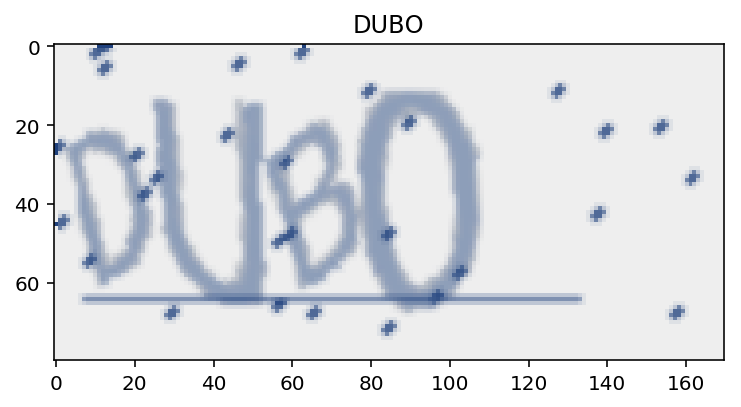

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)+1

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

In [4]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
x = Lambda(lambda x:(x-127.5)/127.5)(x)
for i in range(3):
    for j in range(2):
        x = Convolution2D(32*2**i, 3, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

conv_shape = x.get_shape().as_list()
rnn_length = conv_shape[1]
rnn_dimen = conv_shape[2]*conv_shape[3]
print(conv_shape, rnn_length, rnn_dimen)
x = Reshape(target_shape=(rnn_length, rnn_dimen))(x)
rnn_length -= 2

x = Dense(rnn_size, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru1_b')(x)
x = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', name='gru2')(x)
gru_2b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru2_b')(x)
x = concatenate([gru_2, gru_2b])

x = Dropout(0.2)(x)
x = Dense(n_class, activation='softmax')(x)
base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

[None, 17, 6, 128] 17 768


In [6]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*rnn_length, np.ones(batch_size)*n_len], np.ones(batch_size)

(1, 170, 80, 3) [[ 6  5 13 10]] [15.] [4.]


Text(0.5,1,'65DA')

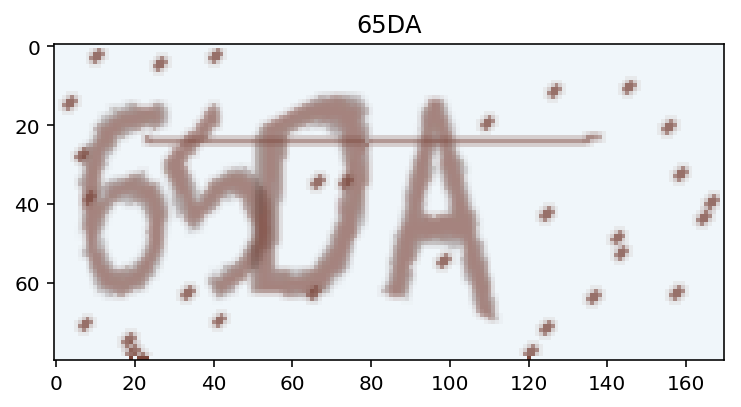

In [7]:
(X_vis, y_vis, input_length_vis, label_length_vis), _ = next(gen(1))
print(X_vis.shape, y_vis, input_length_vis, label_length_vis)

plt.imshow(X_vis[0].transpose(1, 0, 2))
plt.title(''.join([characters[i] for i in y_vis[0]]))

In [8]:
def evaluate(batch_size=128, steps=10):
    batch_acc = 0
    generator = gen(batch_size)
    for i in range(steps):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :n_len]
        if out.shape[1] == n_len:
            batch_acc += (y_test == out).all(axis=1).mean()
    return batch_acc / steps

In [9]:
from keras.callbacks import *

class Evaluator(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(steps=20)*100
        self.accs.append(acc)
        print('')
        print('acc: %f%%' % acc)

evaluator = Evaluator()

In [ ]:
h = model.fit_generator(gen(128), steps_per_epoch=400, epochs=20,
                        callbacks=[evaluator],
                        validation_data=gen(128), validation_steps=20)

model.save('mymodel.h5')

Epoch 1/20
400/400 [==============================] - 8501s 21s/step - loss: 8.7734 - val_loss: 1.3542

acc: 82.031250%
Epoch 2/20
306/400 [=====================>........] - ETA: 32:33 - loss: 0.7538